This notebook is based on [Quantum Boltzmann Machine (M. H. Amin, et al., 2018)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.021050).

Original code from [mareksubocz/QRBM](https://github.com/mareksubocz/QRBM).

In [1]:
cd /home/r09222027/GitHub/QBM/

/home/r09222027/GitHub/QBM


In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from scipy.linalg import expm
%matplotlib inline

from multiprocessing import Pool
import os
pool = Pool(os.cpu_count())

# Dataset Generation

In [3]:
class RandomVectorDataset(Dataset):
    """
    Create a random spin vector dataset with multiple modes, each centered at a (random generated) centerpoint with success probability p.
    """
    def __init__(self, N, modes, p, dataset_size, sd=None):
        super().__init__()

        np.random.seed(sd)
        center_lst = []
        dataset_lst = []
        for mode in range(modes):
            s = np.random.binomial(1, 0.5, N)
            center_lst.append(2*s - 1)
            # dataset_lst.append([])
            for _ in range(dataset_size):
                data = 2*(np.random.binomial(1, p, N) == s) - 1
                # dataset_lst[-1].append(data)
                dataset_lst.append(data)

        self.N = N
        self.p = p
        self.centers = center_lst
        self.samples = dataset_lst

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]
    
    def get_prob(self, state):
        prob = 0
        for c in self.centers:
            hamming_dist = np.sum(np.abs(c - state)) / 2
            prob += self.p**(self.N - hamming_dist) * (1 - self.p)**hamming_dist
        prob /= len(self.centers)
        return prob

In [89]:
N = 5
modes = 1
p = 0.9
dataset_size = 100
seed = 0

dataset = RandomVectorDataset(N, modes, p, dataset_size, seed)
dataset.centers

[array([ 1,  1,  1,  1, -1])]

In [90]:
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=0)

# Training Sessions

lr=0.11

In [257]:
qbm0 = QBM(5, 2, rng_sd=0)
qbm0.train(dataset, data_prob=dataset.get_prob, lr=0.11)

Batch: 1/10


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Batch: 2/10


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Batch: 3/10


100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


Batch: 4/10


100%|██████████| 10/10 [00:01<00:00,  5.79it/s]


Batch: 5/10


100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


Batch: 6/10


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Batch: 7/10


100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


Batch: 8/10


100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


Batch: 9/10


100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


Batch: 10/10


100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


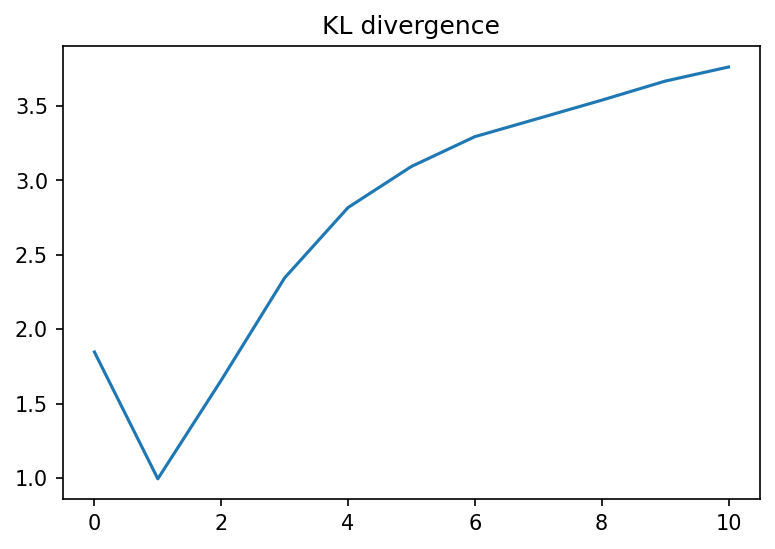

In [258]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(qbm0.KL_history)

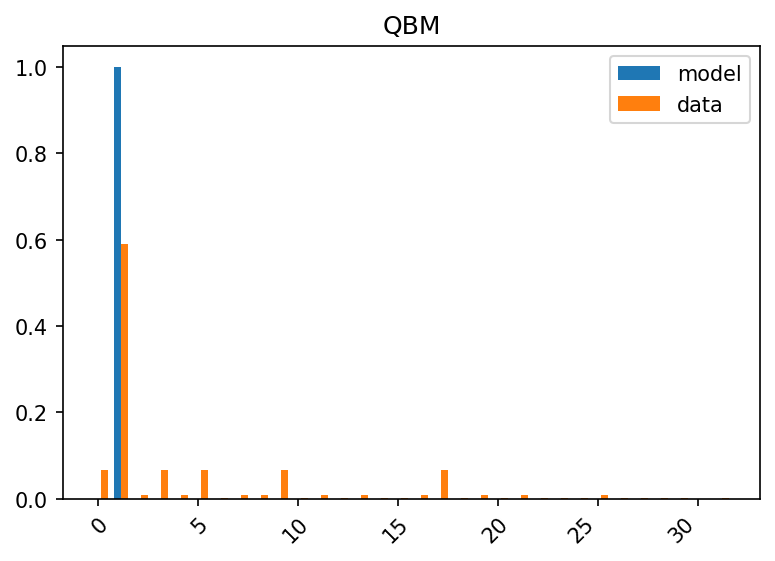

In [259]:
histo_cat = np.arange(2**qbm0.n_vis)
histo_model = [qbm0.get_prob(s, use_stored_var=True) for s in range(2**qbm0.n_vis)]
histo_data = [dataset.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm0.n_vis}}'), dtype=int)) for s in range(2**qbm0.n_vis)]

bar_width = 0.35

plt.figure(dpi=150)
plt.title('QBM')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

lr=0.033

In [260]:
qbm1 = QBM(5, 2, rng_sd=0)
qbm1.train(dataset, data_prob=dataset.get_prob, lr=0.033)

Batch: 1/10


100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


Batch: 2/10


100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


Batch: 3/10


100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


Batch: 4/10


100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


Batch: 5/10


100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


Batch: 6/10


100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


Batch: 7/10


100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


Batch: 8/10


100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


Batch: 9/10


100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


Batch: 10/10


100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


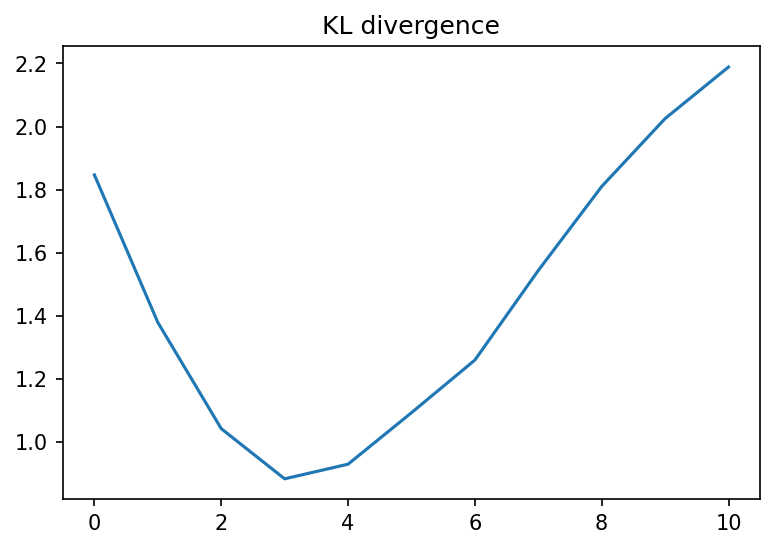

In [261]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(qbm1.KL_history)

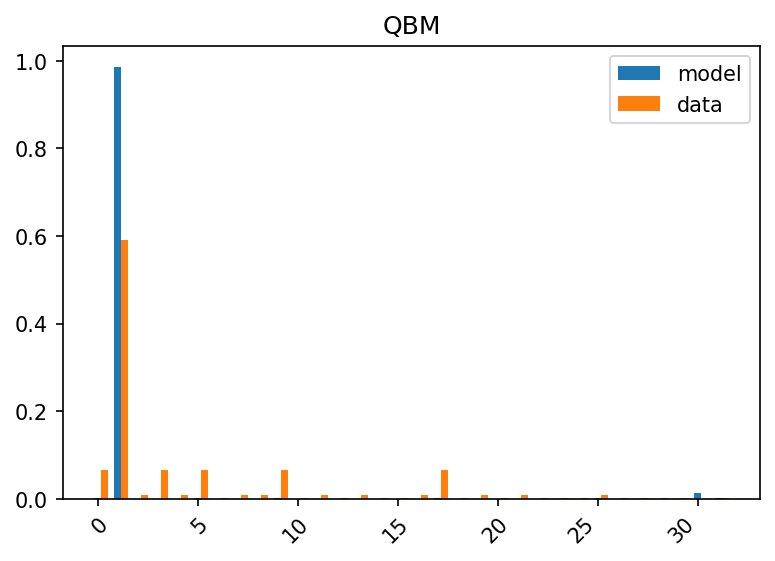

In [262]:
histo_cat = np.arange(2**qbm1.n_vis)
histo_model = [qbm1.get_prob(s, use_stored_var=True) for s in range(2**qbm1.n_vis)]
histo_data = [dataset.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm1.n_vis}}'), dtype=int)) for s in range(2**qbm1.n_vis)]

bar_width = 0.35

plt.figure(dpi=150)
plt.title('QBM')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

lr = 0.075, lr_decay = 0.25

In [263]:
qbm2 = QBM(5, 2, rng_sd=2)
qbm2.train(dataset, data_prob=dataset.get_prob, lr=0.075, lr_decay=0.25)

Batch: 1/10


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Batch: 2/10


100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


Batch: 3/10


100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


Batch: 4/10


100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


Batch: 5/10


100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


Batch: 6/10


100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


Batch: 7/10


100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


Batch: 8/10


100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Batch: 9/10


100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


Batch: 10/10


100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


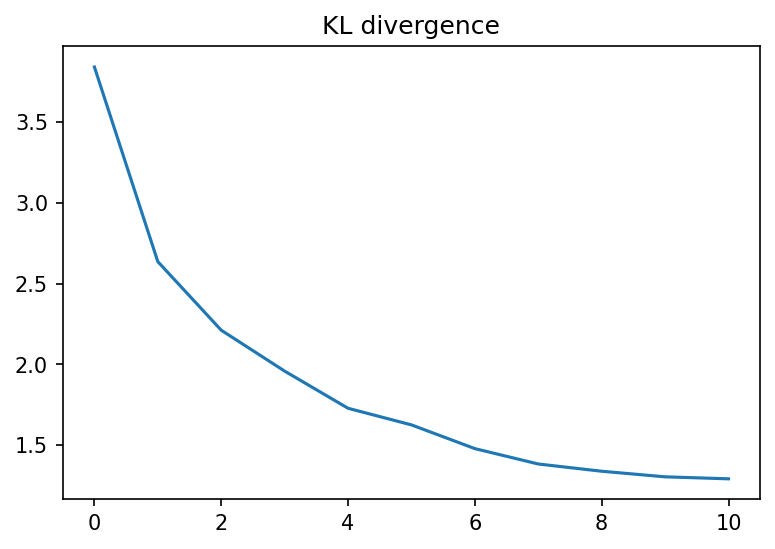

In [264]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(qbm2.KL_history)

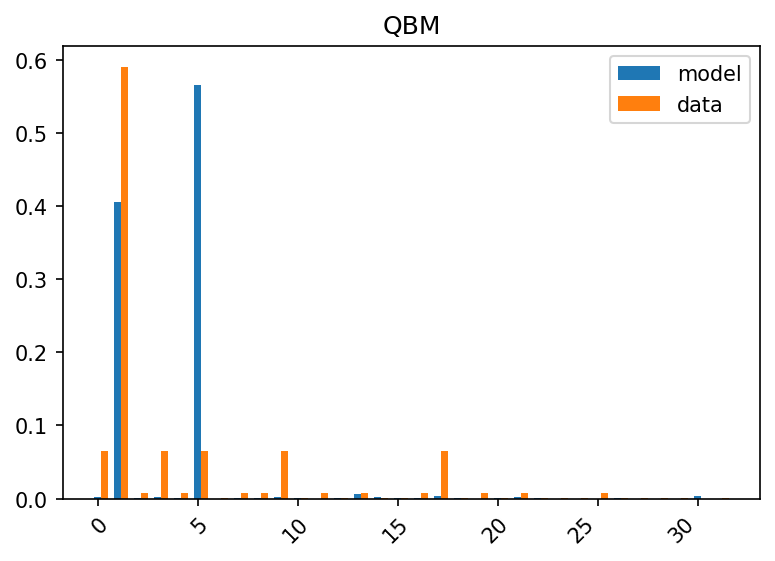

In [265]:
histo_cat = np.arange(2**qbm2.n_vis)
histo_model = [qbm2.get_prob(s, use_stored_var=True) for s in range(2**qbm2.n_vis)]
histo_data = [dataset.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm2.n_vis}}'), dtype=int)) for s in range(2**qbm2.n_vis)]

bar_width = 0.35

plt.figure(dpi=150)
plt.title('QBM')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

## L1, L2 regularization (smaller for b, larger for w)

Local fields b seems harder to train

lr=0.085, l1w=1, l2b=0.25 seems good <- nah

In [145]:
qbm3 = QBM(5, 2, Gamma=0.3, rng_sd=10)
qbm3.train(dataset, data_prob=dataset.get_prob, lr=0.085, l1w=1, l2b=0.55)

Batch: 1/10


100%|██████████| 10/10 [00:01<00:00,  8.19it/s]


Batch: 2/10


100%|██████████| 10/10 [00:00<00:00, 10.16it/s]


Batch: 3/10


100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


Batch: 4/10


100%|██████████| 10/10 [00:01<00:00,  7.81it/s]


Batch: 5/10


100%|██████████| 10/10 [00:01<00:00,  8.34it/s]


Batch: 6/10


100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Batch: 7/10


100%|██████████| 10/10 [00:01<00:00,  8.97it/s]


Batch: 8/10


100%|██████████| 10/10 [00:01<00:00,  7.53it/s]


Batch: 9/10


100%|██████████| 10/10 [00:01<00:00,  9.89it/s]


Batch: 10/10


100%|██████████| 10/10 [00:01<00:00,  7.88it/s]


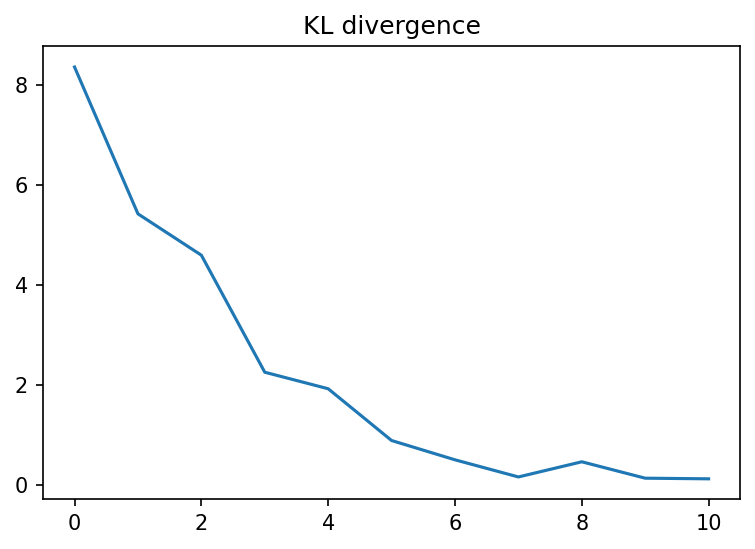

In [146]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(qbm3.KL_history)

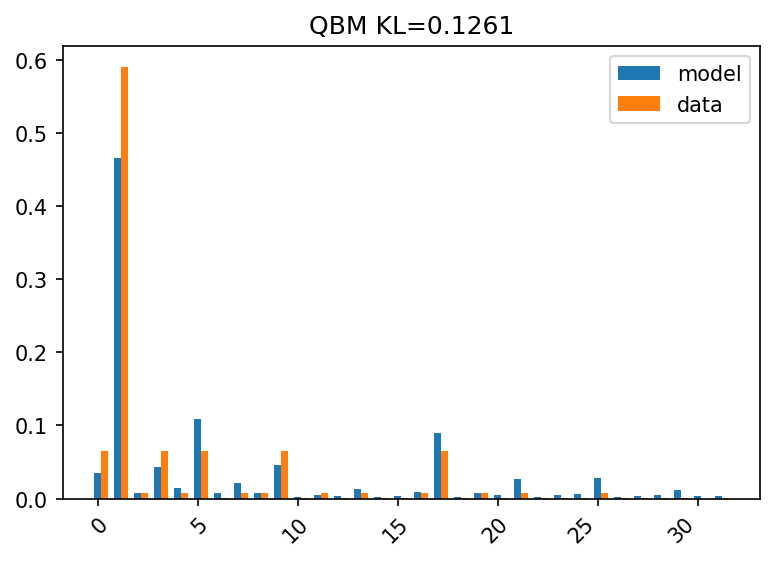

In [147]:
histo_cat = np.arange(2**qbm3.n_vis)
histo_model = [qbm3.get_prob(s, use_stored_var=True) for s in range(2**qbm3.n_vis)]
histo_data = [dataset.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm3.n_vis}}'), dtype=int)) for s in range(2**qbm3.n_vis)]

bar_width = 0.35

plt.figure(dpi=150)
plt.title(f'QBM KL={qbm3.get_KL(dataset.get_prob):.4f}')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

## SRQBM
The KL divergence to iteration curve is a lot smoother than the QBM counterpart.

In [151]:
srqbm1 = SRQBM(5, 2, Gamma=0.3, rng_sd=10)
srqbm1.train(dataset, data_prob=dataset.get_prob, lr=0.085, l1w=1, l2b=0.55)

100%|██████████| 10/10 [01:07<00:00,  6.72s/it]


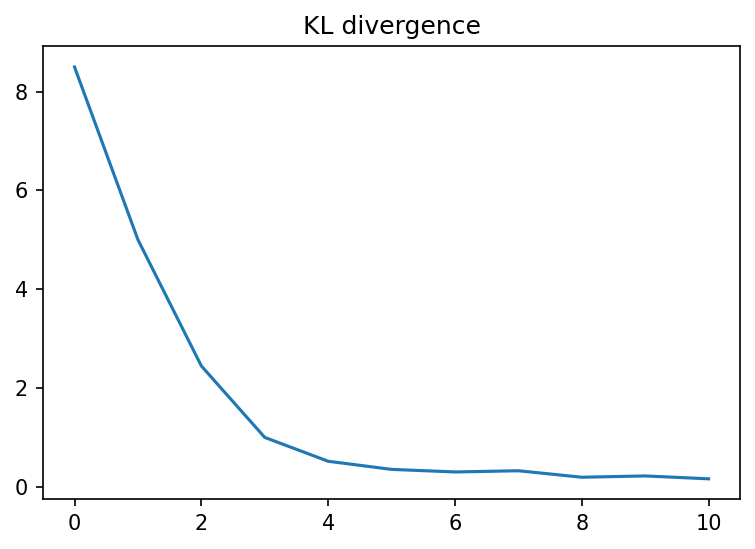

In [152]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(srqbm1.KL_history)

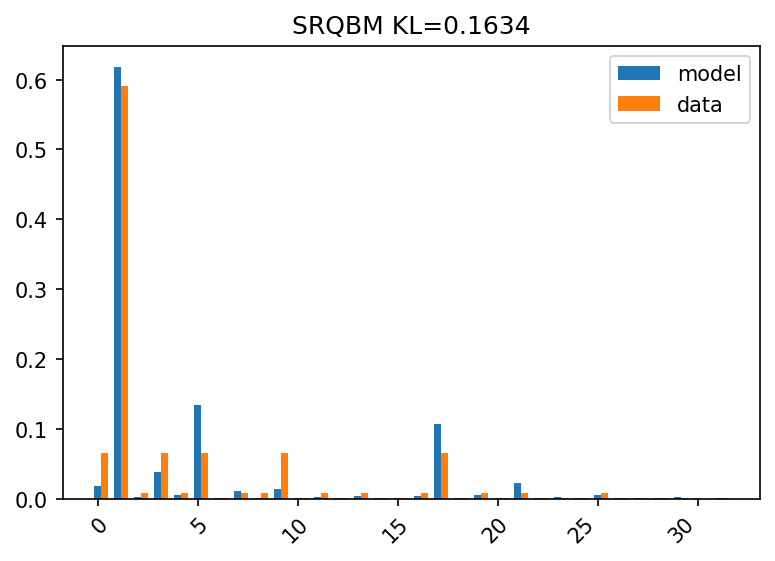

In [153]:
histo_cat = np.arange(2**srqbm1.n_vis)
histo_model = [srqbm1.get_prob(s, use_stored_var=True) for s in range(2**srqbm1.n_vis)]
histo_data = [dataset.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{srqbm1.n_vis}}'), dtype=int)) for s in range(2**srqbm1.n_vis)]

bar_width = 0.35

plt.figure(dpi=150)
plt.title(f'SRQBM KL={srqbm1.get_KL(dataset.get_prob):.4f}')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

# Larger dataset

In [12]:
N = 8
modes = 8
p = 0.9
dataset_size = 1000
seed = 1

dataset2 = RandomVectorDataset(N, modes, p, dataset_size, seed)
dataset2.centers

[array([-1,  1, -1, -1, -1, -1, -1, -1]),
 array([-1, -1, -1, -1, -1, -1,  1, -1]),
 array([-1,  1,  1,  1,  1, -1,  1,  1]),
 array([ 1,  1, -1,  1, -1,  1, -1,  1]),
 array([-1, -1, -1,  1,  1,  1,  1,  1]),
 array([ 1, -1, -1,  1,  1, -1,  1, -1]),
 array([ 1,  1,  1, -1, -1,  1, -1, -1]),
 array([ 1, -1,  1,  1, -1,  1, -1,  1])]

In [427]:
qbm4 = QBM(8, 2, Gamma=2, rng_sd=0)
qbm4.train(dataset2, data_prob=dataset2.get_prob, get_weights_history=True,
             lr=0.09300449987389166,
             l1w=0.010558221885442323,
             l1b=0.3425720479042153,
             l2w=0.4483180388667832,
             l2b=0.22712156668703617,
             batches=200)

Batch: 1/100


100%|██████████| 80/80 [00:04<00:00, 16.29it/s]


Batch: 2/100


100%|██████████| 80/80 [00:05<00:00, 14.59it/s]


Batch: 3/100


100%|██████████| 80/80 [00:05<00:00, 15.81it/s]


Batch: 4/100


100%|██████████| 80/80 [00:05<00:00, 14.24it/s]


Batch: 5/100


100%|██████████| 80/80 [00:06<00:00, 12.10it/s]


Batch: 6/100


100%|██████████| 80/80 [00:04<00:00, 17.34it/s]


Batch: 7/100


100%|██████████| 80/80 [00:05<00:00, 14.89it/s]


Batch: 8/100


100%|██████████| 80/80 [00:05<00:00, 14.48it/s]


Batch: 9/100


100%|██████████| 80/80 [00:05<00:00, 15.15it/s]


Batch: 10/100


100%|██████████| 80/80 [00:05<00:00, 14.81it/s]


Batch: 11/100


100%|██████████| 80/80 [00:05<00:00, 15.29it/s]


Batch: 12/100


100%|██████████| 80/80 [00:05<00:00, 15.07it/s]


Batch: 13/100


100%|██████████| 80/80 [00:05<00:00, 14.73it/s]


Batch: 14/100


100%|██████████| 80/80 [00:05<00:00, 14.82it/s]


Batch: 15/100


100%|██████████| 80/80 [00:05<00:00, 14.99it/s]


Batch: 16/100


100%|██████████| 80/80 [00:05<00:00, 13.65it/s]


Batch: 17/100


100%|██████████| 80/80 [00:04<00:00, 16.64it/s]


Batch: 18/100


100%|██████████| 80/80 [00:05<00:00, 15.24it/s]


Batch: 19/100


100%|██████████| 80/80 [00:05<00:00, 14.87it/s]


Batch: 20/100


100%|██████████| 80/80 [00:04<00:00, 16.50it/s]


Batch: 21/100


100%|██████████| 80/80 [00:05<00:00, 15.69it/s]


Batch: 22/100


100%|██████████| 80/80 [00:05<00:00, 14.81it/s]


Batch: 23/100


100%|██████████| 80/80 [00:05<00:00, 13.77it/s]


Batch: 24/100


100%|██████████| 80/80 [00:05<00:00, 13.61it/s]


Batch: 25/100


100%|██████████| 80/80 [00:05<00:00, 15.53it/s]


Batch: 26/100


100%|██████████| 80/80 [00:05<00:00, 14.51it/s]


Batch: 27/100


100%|██████████| 80/80 [00:05<00:00, 15.03it/s]


Batch: 28/100


100%|██████████| 80/80 [00:05<00:00, 13.73it/s]


Batch: 29/100


100%|██████████| 80/80 [00:05<00:00, 13.94it/s]


Batch: 30/100


100%|██████████| 80/80 [00:05<00:00, 14.40it/s]


Batch: 31/100


100%|██████████| 80/80 [00:04<00:00, 16.37it/s]


Batch: 32/100


100%|██████████| 80/80 [00:05<00:00, 13.47it/s]


Batch: 33/100


100%|██████████| 80/80 [00:05<00:00, 13.58it/s]


Batch: 34/100


100%|██████████| 80/80 [00:05<00:00, 15.77it/s]


Batch: 35/100


100%|██████████| 80/80 [00:05<00:00, 14.31it/s]


Batch: 36/100


100%|██████████| 80/80 [00:05<00:00, 14.99it/s]


Batch: 37/100


100%|██████████| 80/80 [00:04<00:00, 16.37it/s]


Batch: 38/100


100%|██████████| 80/80 [00:05<00:00, 15.16it/s]


Batch: 39/100


100%|██████████| 80/80 [00:05<00:00, 15.68it/s]


Batch: 40/100


100%|██████████| 80/80 [00:05<00:00, 14.09it/s]


Batch: 41/100


100%|██████████| 80/80 [00:05<00:00, 15.70it/s]


Batch: 42/100


100%|██████████| 80/80 [00:05<00:00, 13.93it/s]


Batch: 43/100


100%|██████████| 80/80 [00:05<00:00, 15.83it/s]


Batch: 44/100


100%|██████████| 80/80 [00:05<00:00, 15.23it/s]


Batch: 45/100


100%|██████████| 80/80 [00:05<00:00, 14.66it/s]


Batch: 46/100


100%|██████████| 80/80 [00:05<00:00, 14.20it/s]


Batch: 47/100


100%|██████████| 80/80 [00:04<00:00, 16.99it/s]


Batch: 48/100


100%|██████████| 80/80 [00:05<00:00, 13.98it/s]


Batch: 49/100


100%|██████████| 80/80 [00:05<00:00, 15.05it/s]


Batch: 50/100


100%|██████████| 80/80 [00:05<00:00, 14.49it/s]


Batch: 51/100


100%|██████████| 80/80 [00:05<00:00, 14.18it/s]


Batch: 52/100


100%|██████████| 80/80 [00:05<00:00, 15.00it/s]


Batch: 53/100


100%|██████████| 80/80 [00:06<00:00, 13.01it/s]


Batch: 54/100


100%|██████████| 80/80 [00:06<00:00, 13.31it/s]


Batch: 55/100


100%|██████████| 80/80 [00:05<00:00, 14.87it/s]


Batch: 56/100


100%|██████████| 80/80 [00:05<00:00, 15.26it/s]


Batch: 57/100


100%|██████████| 80/80 [00:05<00:00, 14.39it/s]


Batch: 58/100


100%|██████████| 80/80 [00:05<00:00, 14.88it/s]


Batch: 59/100


100%|██████████| 80/80 [00:05<00:00, 15.68it/s]


Batch: 60/100


100%|██████████| 80/80 [00:05<00:00, 14.38it/s]


Batch: 61/100


100%|██████████| 80/80 [00:05<00:00, 15.48it/s]


Batch: 62/100


100%|██████████| 80/80 [00:05<00:00, 15.21it/s]


Batch: 63/100


100%|██████████| 80/80 [00:05<00:00, 13.68it/s]


Batch: 64/100


100%|██████████| 80/80 [00:04<00:00, 16.57it/s]


Batch: 65/100


100%|██████████| 80/80 [00:05<00:00, 14.44it/s]


Batch: 66/100


100%|██████████| 80/80 [00:05<00:00, 14.94it/s]


Batch: 67/100


100%|██████████| 80/80 [00:05<00:00, 15.71it/s]


Batch: 68/100


100%|██████████| 80/80 [00:05<00:00, 14.91it/s]


Batch: 69/100


100%|██████████| 80/80 [00:05<00:00, 13.90it/s]


Batch: 70/100


100%|██████████| 80/80 [00:05<00:00, 15.42it/s]


Batch: 71/100


100%|██████████| 80/80 [00:05<00:00, 15.30it/s]


Batch: 72/100


100%|██████████| 80/80 [00:05<00:00, 14.97it/s]


Batch: 73/100


100%|██████████| 80/80 [00:05<00:00, 15.99it/s]


Batch: 74/100


100%|██████████| 80/80 [00:05<00:00, 14.14it/s]


Batch: 75/100


100%|██████████| 80/80 [00:05<00:00, 15.69it/s]


Batch: 76/100


100%|██████████| 80/80 [00:05<00:00, 15.00it/s]


Batch: 77/100


100%|██████████| 80/80 [00:05<00:00, 14.05it/s]


Batch: 78/100


100%|██████████| 80/80 [00:05<00:00, 15.13it/s]


Batch: 79/100


100%|██████████| 80/80 [00:05<00:00, 14.14it/s]


Batch: 80/100


100%|██████████| 80/80 [00:05<00:00, 13.91it/s]


Batch: 81/100


100%|██████████| 80/80 [00:05<00:00, 15.61it/s]


Batch: 82/100


100%|██████████| 80/80 [00:05<00:00, 14.07it/s]


Batch: 83/100


100%|██████████| 80/80 [00:05<00:00, 15.41it/s]


Batch: 84/100


100%|██████████| 80/80 [00:05<00:00, 15.07it/s]


Batch: 85/100


100%|██████████| 80/80 [00:05<00:00, 14.38it/s]


Batch: 86/100


100%|██████████| 80/80 [00:04<00:00, 16.78it/s]


Batch: 87/100


100%|██████████| 80/80 [00:05<00:00, 15.12it/s]


Batch: 88/100


100%|██████████| 80/80 [00:05<00:00, 14.21it/s]


Batch: 89/100


100%|██████████| 80/80 [00:04<00:00, 16.31it/s]


Batch: 90/100


100%|██████████| 80/80 [00:05<00:00, 14.24it/s]


Batch: 91/100


100%|██████████| 80/80 [00:05<00:00, 14.80it/s]


Batch: 92/100


100%|██████████| 80/80 [00:05<00:00, 14.29it/s]


Batch: 93/100


100%|██████████| 80/80 [00:05<00:00, 15.78it/s]


Batch: 94/100


100%|██████████| 80/80 [00:06<00:00, 13.01it/s]


Batch: 95/100


100%|██████████| 80/80 [00:05<00:00, 14.05it/s]


Batch: 96/100


100%|██████████| 80/80 [00:05<00:00, 15.18it/s]


Batch: 97/100


100%|██████████| 80/80 [00:05<00:00, 15.88it/s]


Batch: 98/100


100%|██████████| 80/80 [00:05<00:00, 15.40it/s]


Batch: 99/100


100%|██████████| 80/80 [00:05<00:00, 14.83it/s]


Batch: 100/100


100%|██████████| 80/80 [00:05<00:00, 14.04it/s]


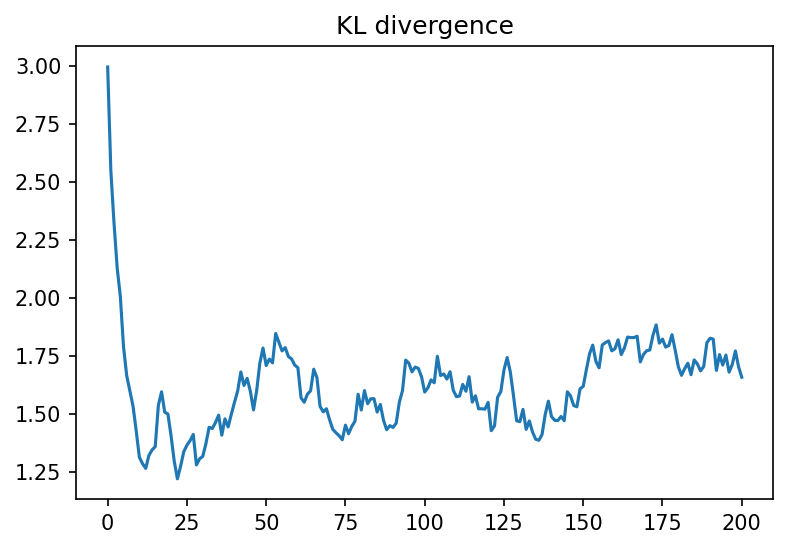

In [22]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(qbm4.KL_history)

In [23]:
min(qbm4.KL_history)

1.220567973395785

In [24]:
qbm4.set_weights(*qbm4.weights_history[qbm4.KL_history.index(min(qbm4.KL_history))])

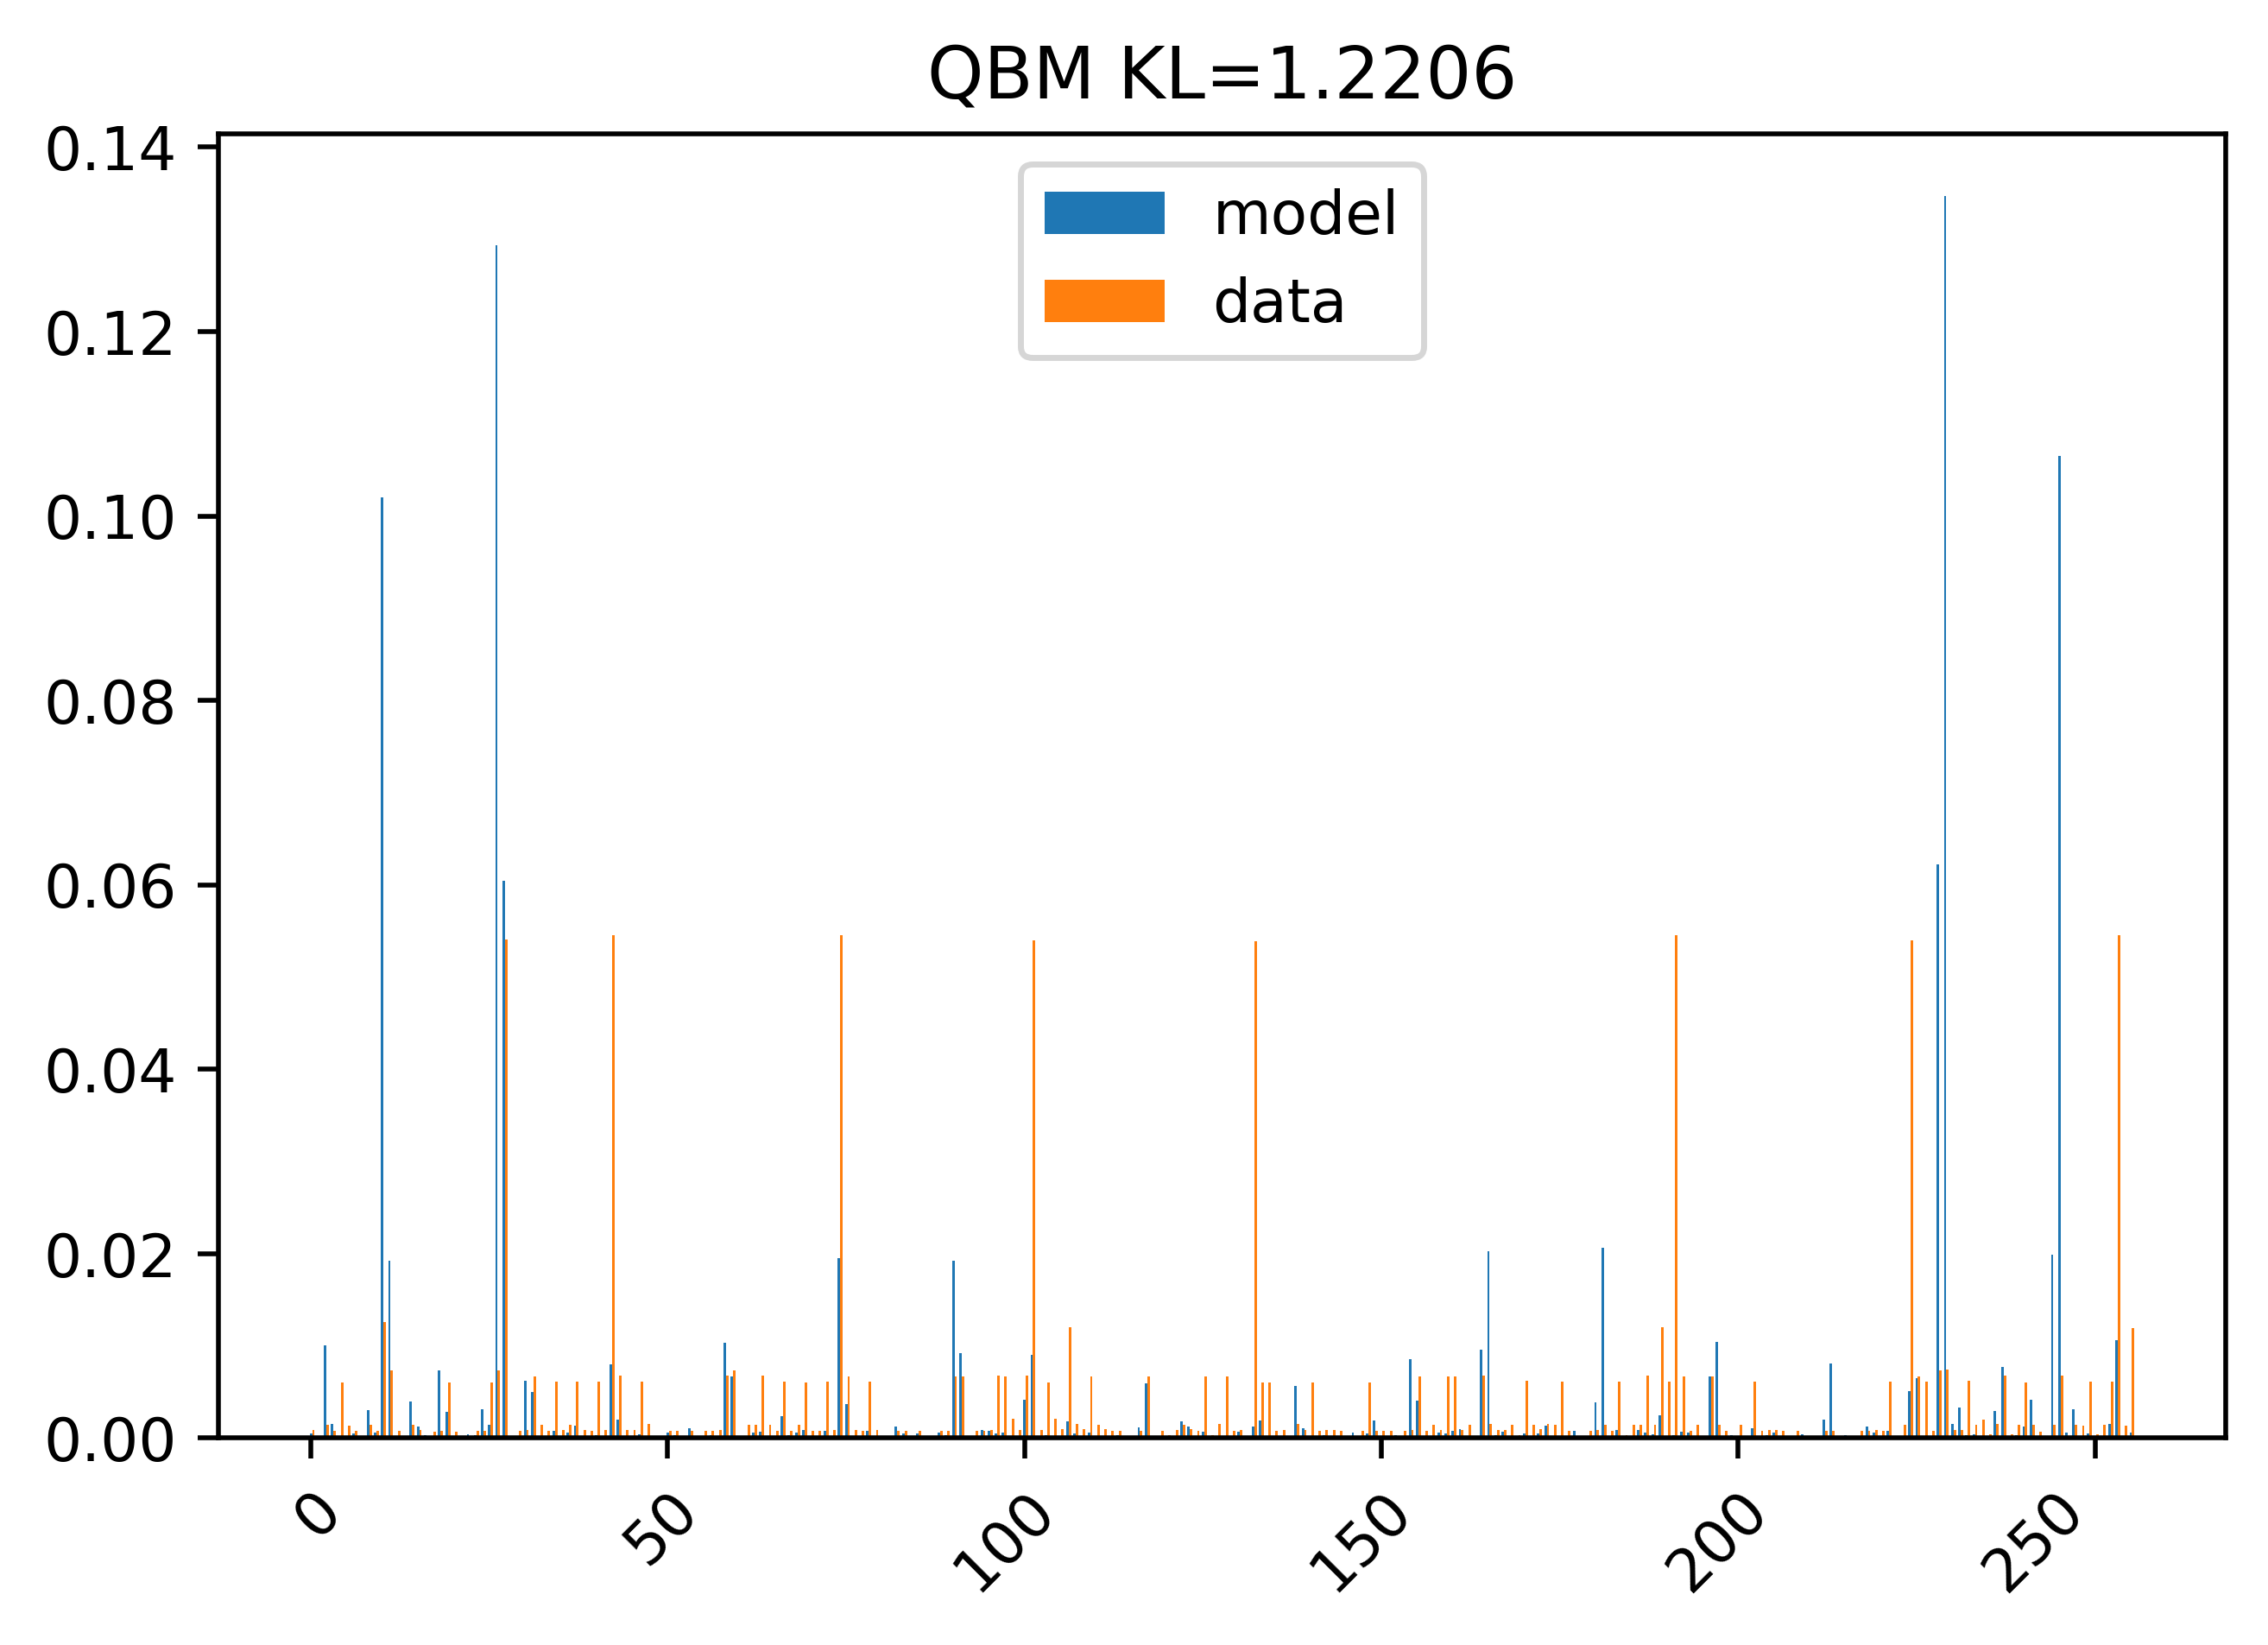

In [26]:
qbm4.get_rho()

histo_model = [qbm4.get_prob(s, use_stored_var=True) for s in range(2**qbm4.n_vis)]
histo_data = [dataset2.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm4.n_vis}}'), dtype=int)) for s in range(2**qbm4.n_vis)]

histo_cat = np.arange(2**qbm4.n_vis)
# histo_model = [qbm4.get_prob(s, use_stored_var=True) for s in range(2**qbm4.n_vis)]
# histo_data = [dataset2.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm4.n_vis}}'), dtype=int)) for s in range(2**qbm4.n_vis)]

bar_width = 0.35

plt.figure(dpi=500)
plt.title(f'QBM KL={min(qbm4.KL_history):.4f}')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

In [15]:
# lr=0.02, l2w=0.8, l2b=0.5: KL=0.63
# lr=0.3, l1w=0.5, l2b=0.2: KL=0.71
srqbm2 = SRQBM(8, 2, Gamma=2, rng_sd=0)
srqbm2.train(dataset2, data_prob=dataset2.get_prob, get_weights_history=True,
             lr=0.09300449987389166,
             l1w=0.010558221885442323,
             l1b=0.3425720479042153,
             l2w=0.4483180388667832,
             l2b=0.22712156668703617,
             batches=200)

100%|██████████| 200/200 [02:35<00:00,  1.28it/s]


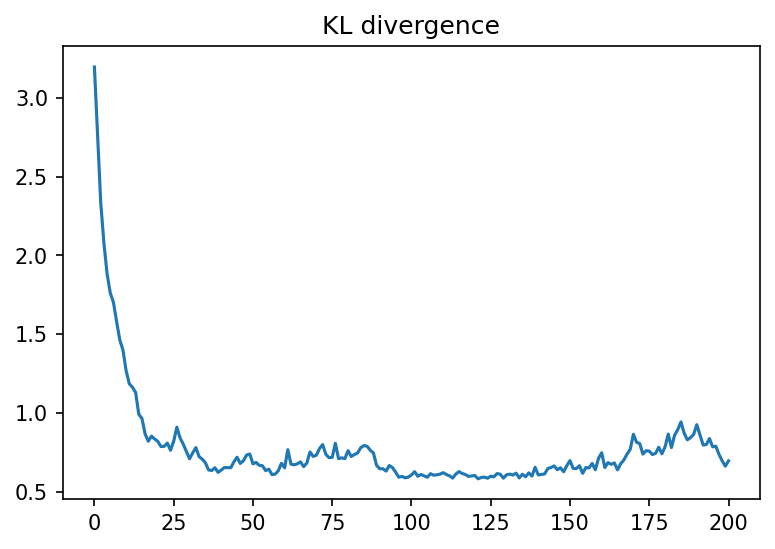

In [16]:
plt.figure(dpi=150)
plt.title('KL divergence')
plt.plot(srqbm2.KL_history)

In [17]:
min(srqbm2.KL_history)

0.5834562860737509

In [18]:
srqbm2.set_weights(*srqbm2.weights_history[srqbm2.KL_history.index(min(srqbm2.KL_history))])

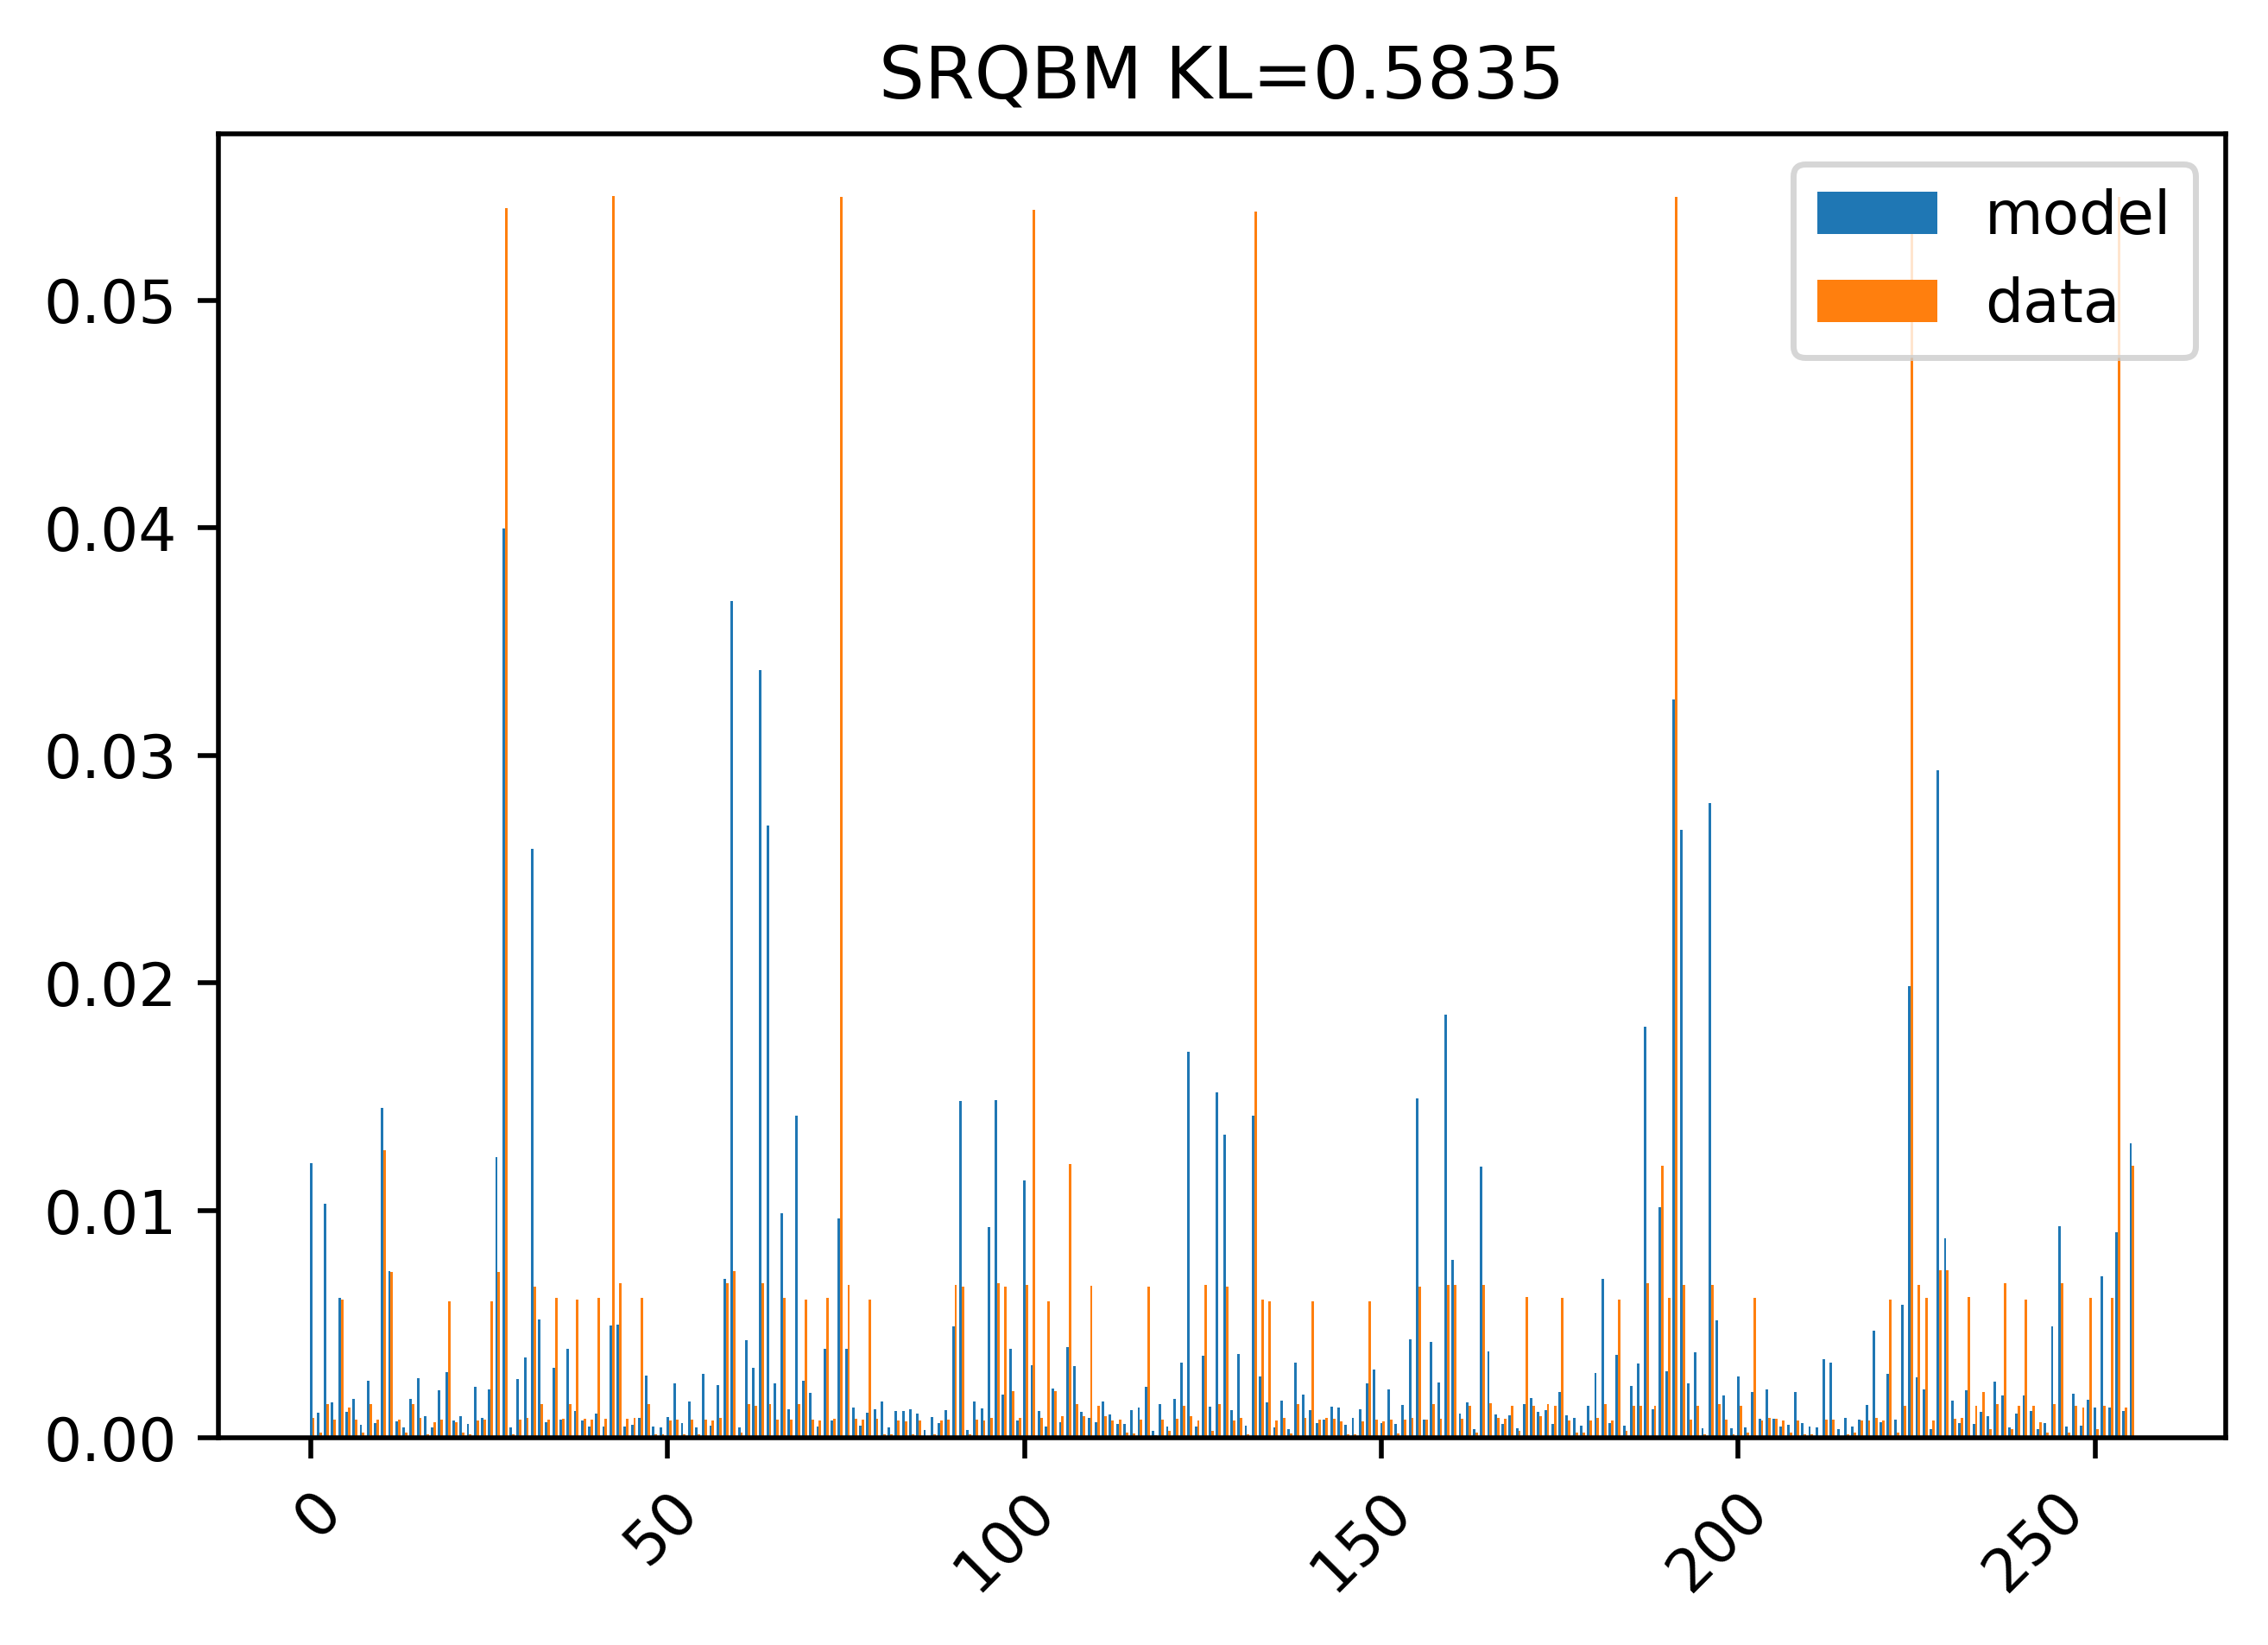

In [25]:
srqbm2.get_rho()

histo_model = [srqbm2.get_prob(s, use_stored_var=True) for s in range(2**srqbm2.n_vis)]
histo_data = [dataset2.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{srqbm2.n_vis}}'), dtype=int)) for s in range(2**srqbm2.n_vis)]

histo_cat = np.arange(2**srqbm2.n_vis)
# histo_model = [qbm4.get_prob(s, use_stored_var=True) for s in range(2**qbm4.n_vis)]
# histo_data = [dataset2.get_prob(1 - 2 * np.array(list(f'{f"{s:b}":0>{qbm4.n_vis}}'), dtype=int)) for s in range(2**qbm4.n_vis)]

bar_width = 0.35

plt.figure(dpi=500)
plt.title(f'SRQBM KL={min(srqbm2.KL_history):.4f}')
# plt.title(f'SRQBM')
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.bar(histo_cat, histo_model, label='model', width=bar_width)
plt.bar(histo_cat + bar_width, histo_data, label='data', width=bar_width)
plt.legend()

# Use optuna to tune hyperparameters

In [10]:
def objective(trial):
    lr = trial.suggest_float('lr', 0, 0.1)
    l1w = trial.suggest_float('l1w', 0, 1)
    l1b = trial.suggest_float('l1b', 0, 1)
    l2w = trial.suggest_float('l2w', 0, 1)
    l2b = trial.suggest_float('l2b', 0, 1)

    srqbm3 = SRQBM(8, 2, Gamma=2, use_tqdm=False, rng_sd=0)
    srqbm3.train(dataset2, data_prob=dataset2.get_prob, get_weights_history=True, lr=lr, l1w=l1w, l1b=l1b, l2w=l2w, l2b=l2b, batches=100)
    return min(srqbm3.KL_history)

In [13]:
import optuna

study = optuna.create_study()
study.optimize(objective, n_trials=100)

[I 2021-11-30 18:45:59,855] A new study created in memory with name: no-name-2488c3a9-8a02-4dcf-9b0c-b8c0eafe1049


In [14]:
study.best_params

{'lr': 0.09300449987389166,
 'l1w': 0.010558221885442323,
 'l1b': 0.3425720479042153,
 'l2w': 0.4483180388667832,
 'l2b': 0.22712156668703617}

# Quantum Boltzmann Machine

In [4]:
pauli_x = np.array([[0, 1], [1, 0]])
flat_z = np.array([1, -1])

In [5]:
def x_at(n, i):
    """
    pauli_x at spin i within a total of n spins
    """
    # if i == 0:
    #     return np.kron(pauli_x, np.eye(2**(n-1), dtype=int))
    # if i == n-1:
    #     return np.kron(np.eye(2**(n-1), dtype=int), pauli_x)
    return np.kron(np.kron(np.eye(2**i, dtype=int), pauli_x), np.eye(2**(n-1-i), dtype=int))

In [6]:
def flat_z_at(n, i, j=None):
    """
    pauli_z at spin i (and spin j, with i < j) within a total of n spins
    """
    # if j is not None:
    #     if i == j:
    #         return np.ones(2**n)
    #     b, s = (i, j) if i < j else (j, i)
    #     return np.kron(np.kron(np.kron(np.kron(np.ones(2**b, dtype=int), flat_z),
    #              np.ones(2**(s-1-b), dtype=int)), flat_z), np.ones(2**(n-1-s), dtype=int))
    # return np.kron(np.kron(np.ones(2**i, dtype=int), flat_z), np.ones(2**(n-1-i), dtype=int))

    output = np.ones(2**n, dtype=int)
    ind = np.arange(2**n)

    output[ind // 2**(n-1-i) % 2 == 1] *= -1

    if j is not None:
        output[ind // 2**(n-1-j) % 2 == 1] *= -1
    
    return output

In [8]:
class QBM:
    """
    A general quantum Boltzmann machine class. No restrictions on the connection between nodes.
    Variables are binary (\pm 1).
    """
    def __init__(self,
                 n_vis,
                 n_hid,
                 sampler='QMC',
                 Gamma=0.1,
                 M=11,
                 rng_sd=None,
                 use_tqdm=True):

        # if err_function not in {'mse', 'cosine'}:
        #     raise ValueError('err_function should be either \'mse\' or \'cosine\'')

        # progress bar
        # self._use_tqdm = use_tqdm
        # self._tqdm = None

        if use_tqdm:
            from tqdm import tqdm
            self._tqdm = tqdm
        else:
            self._tqdm = lambda x: x

        self.n_vis = n_vis
        self.n_hid = n_hid
        self.n = n_vis + n_hid
        self.sampler = sampler
        self.Gamma = Gamma
        self.M = M
        self.sd = rng_sd

        self.sum_x = np.zeros((2**self.n, 2**self.n))
        for i in range(self.n):
            self.sum_x += x_at(self.n, i)

        self.z_as_columns = np.array([flat_z_at(self.n, i) for i in range(self.n)]).T
        self.zz_as_columns = np.array([[flat_z_at(self.n, i, j) for i in range(self.n)] for j in range(self.n)]).transpose(2, 0, 1)

        # Convention:
        # varibales 0 to (n_vis - 1) represent visible nodes;
        # variables n_vis to (n - 1) represent hidden nodes;
        # energy = -w_v.dot(visible).dot(visible) - w_h.dot(hidden).dot(hidden) - 2 * w_vh.dot(visible).dot(hidden)
        #        = -w.dot(nodes).dot(nodes) - b.dot(nodes)
        # self.w_v = np.random.uniform(-1, 1, (self.n_vis, self.n_vis))
        # self.w_v = 0.5 * (self.w_v + self.w_v.T)
        # self.w_h = np.random.uniform(-1, 1, (self.n_hid, self.n_hid))
        # self.w_h = 0.5 * (self.w_h + self.w_h.T)
        # self.w_vh = np.random.uniform(-1, 1, (self.n_vis, self.n_hid))

        np.random.seed(rng_sd)
        self.w = np.random.uniform(-1, 1, (self.n, self.n))
        self.w = 0.5 * (self.w + self.w.T) # symmetric
        np.fill_diagonal(self.w, 0)
        self.b = np.random.uniform(-1, 1, self.n)

        self.n_epoch = 0

    def get_weights(self):
        return self.w, self.b

    def set_weights(self, w, b):
        self.w = 0.5 * (w + w.T)
        self.b = b

    def get_H(self):
        """
        Set and return the Hamiltonian in matrix form
        """
        self.H = -self.Gamma * self.sum_x - np.diag(self.z_as_columns.dot(self.b) + np.sum(np.multiply(self.zz_as_columns, self.w), axis=(1, 2)))
        return self.H

    def get_Z(self, use_stored_H=False):
        """
        Set and return the canonical partition function
        """
        if use_stored_H:
            self.Z = np.trace(expm(-self.H))
        else:
            self.Z = np.trace(expm(-self.get_H()))
        return self.Z

    def get_rho(self, use_stored_var=False):
        """
        Set and return the density operator of the system
        """
        if use_stored_var:
            self.rho = expm(-self.H) / self.Z
        else:
            self.rho = expm(-self.get_H()) / self.get_Z()
        return self.rho

    def get_prob(self, state, use_stored_var=False):
        """
        Return the probability associated with a spin state (or its index: [1, -1, -1] -> 011 -> 3)
        """
        # s = (state + 1) // 2
        if state is np.ndarray:
            state_ind = int(str((1-state)//2)[1:-1].replace(' ', ''), 2) # translate spin states to index
        else:
            state_ind = state

        s = np.zeros(2**self.n_vis)
        s[state_ind] = 1

        if use_stored_var:
            return sum(np.diag(self.rho)[state_ind * 2**self.n_hid: (state_ind + 1) * 2**self.n_hid])
            # return np.trace(np.kron(np.outer(s, s), np.eye(2**self.n_hid)).dot(expm(-self.H))) / self.Z
            # return sum([expm(-self.H)[state_ind + i*2**self.n_vis, state_ind + i*2**self.n_vis] for i in range(2**self.n_hid)]) / self.Z
        
        # change dot to slice to speed up
        return sum(np.diag(self.get_rho())[state_ind * 2**self.n_hid: (state_ind + 1) * 2**self.n_hid])
        # return np.trace(np.kron(np.outer(s, s), np.eye(2**self.n_hid)).dot(expm(-self.get_H()))) / self.get_Z()
        # return sum([expm(-self.get_H())[state_ind + i*2**self.n_vis, state_ind + i*2**self.n_vis] for i in range(2**self.n_hid)]) / self.get_Z()

    # def get_energies(self):
    #     self.energies = np.array([self.get_energy(2 * np.array(list(f'{f"{s:b}":0>{self.n}}'), dtype=int) - 1) for s in range(2**self.n)])
    #     return self.energies

    def KL_by_s(self, s, data_prob):
        vis_state = 1 - 2 * np.array(list(f'{f"{s:b}":0>{self.n_vis}}'), dtype=int) # 0100 -> [1, -1, 1, 1]
        return data_prob(vis_state) * math.log(data_prob(vis_state) / self.get_prob(s))

    def get_KL(self, data_prob):
        """
        Return the KL divergence given the data distribution.
        The data distribution data_prob should be a funciton with data_prob(state) = Pr(v = state).
        """
        KL = 0
        # if not exact:
        #     temp_result = [np.sign(s[:self.n_vis]) for s in self.sample(self.w, self.b, self.M, num=100, return_all_states=True)]
        
        for s in range(2**self.n_vis):
            vis_state = 1 - 2 * np.array(list(f'{f"{s:b}":0>{self.n_vis}}'), dtype=int) # 0100 -> [1, -1, 1, 1]
            # if self.n_hid == 0:
            #     model_prob = self.get_prob(vis_state, use_stored_var=(s!=0))
            # else:
            #     model_prob = 0
            #     for h in range(2**self.n_hid):
            #         full_state = 2 * np.array(list(f'{f"{s:b}":0>{self.n_vis}}' + f'{f"{h:b}":0>{self.n_hid}}'), dtype=int) - 1
            #         model_prob += self.get_prob(full_state, use_stored_var=(s!=0))
            # KL += data_prob(vis_state) * math.log(data_prob(vis_state) / model_prob)
            KL += data_prob(vis_state) * math.log(data_prob(vis_state) / self.get_prob(s, use_stored_var=True))
            # if exact:
            #     KL += data_prob(vis_state) * math.log(data_prob(vis_state) / self.get_prob(s))
            # else:
            #     KL += data_prob(vis_state) * math.log(data_prob(vis_state) / temp_result.count(vis_state)) # divided by 0
        
        # # multiprocess
        # KL_results = pool.starmap(QBM.KL_by_s, [(self, s, data_prob) for s in range(2**self.n_vis)])
        # KL = sum(KL_results)

        return KL

    def sample(self, w, h, M, num=10, Gamma0=5, T=0.05, return_all_states=False):
        """
        Sample from the Boltzmann distribution of energy = -w.dot(state).dot(state) - h.dot(state) and average them out
        """
        if self.sampler == 'QMC' or self.sampler == 'SQA':
            from sqa import one_SQA_run
            
            trans_fld_sched = np.linspace(Gamma0, self.Gamma, num=100)

            starargs = [(-w, -h, trans_fld_sched, M, T, self.sd)] * num
            results = pool.starmap(one_SQA_run, starargs)

            # results = []
            # for _ in range(num):
            #     results.append(one_SQA_run(-w, -h, trans_fld_sched, M, T))
            
            if return_all_states:
                return [np.sum(np.reshape(np.array(s), (M, -1)), axis=0) / M for s in results]

            return np.sum(np.reshape(np.array(results), (num * M, -1)), axis=0) / num / M

    def train(self, training_dataset, epochs=1, batches=10, lr=0.1, lr_decay=0, l1w=0, l2w=0, l1b=0, l2b=0, 
              data_prob=None, get_weights_history=True):
        """
        Minimizes the upper bound of likelihood function.
        Updates after each batch. Runs over the whole dataset after each epoch.

        If data_prob is not None, this function also returns the history of KL divergence.

        Parameters:
            lr_decay: Learning rate decay rate after each epoch (lr -> lr * (1-lr_decay))
            l1: Penalty strength associated with L1 regularization
            l2: Penalty strength associated with L2 regularization
        """
        # learning_curve_plot = []
        batch_size = len(training_dataset) // batches
        dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # if epoch_drop is None:
        #     epoch_drop = epochs // 5

        if data_prob is not None:
            self.get_rho()
            self.KL_history = [self.get_KL(data_prob)]

        if get_weights_history:
            self.weights_history = [self.get_weights()]

        # for batch in training_data.shuffle(len(training_data), reshuffle_each_iteration=True).repeat(epochs).batch(batch_size):
        for batch_id, batch in enumerate(dataloader):
            print(f'Batch: {batch_id + 1}/{batches}')
            pos_phase_w = np.zeros((self.n, self.n))
            pos_phase_b = np.zeros(self.n)
            for data in self._tqdm(batch): # parallelizable
                # offset = self.w[:self.n_vis, :self.n_vis].dot(data).dot(data) + self.b[:self.n_vis].dot(data)
                b_eff = 2 * self.w[self.n_vis:, :self.n_vis].dot(data) + self.b[self.n_vis:]
                J_eff = self.w[self.n_vis:, self.n_vis:]

                samp = np.append(data, self.sample(J_eff, b_eff, self.M))
                outer_avg = np.outer(samp, samp)
                np.fill_diagonal(outer_avg, 0)

                pos_phase_w += outer_avg / batch_size
                pos_phase_b += samp / batch_size
                
            samp = self.sample(self.w, self.b, self.M)
            outer_avg = np.outer(samp, samp)
            np.fill_diagonal(outer_avg, 0)
            neg_phase_w = outer_avg
            neg_phase_b = samp

            self.w += lr * (pos_phase_w - neg_phase_w - 2 * l2w * self.w - l1w * (2 * np.heaviside(self.w, 0.5) - 1))
            self.b += lr * (pos_phase_b - neg_phase_b - 2 * l2b * self.b - l1b * (2 * np.heaviside(self.b, 0.5) - 1))

            if data_prob is not None:
                self.get_rho()
                self.KL_history.append(self.get_KL(data_prob))

            if get_weights_history:
                self.weights_history.append(self.get_weights())

            # if epoch % epoch_drop == (epoch_drop - 1):
                
            #     sample_v = v
            #     prob_sample_h = sigmoid(self.hidden_bias + np.dot(v, self.w))
            #     sample_h = (np.random.rand(len(self.hidden_bias)) < prob_sample_h).astype(int)
            #     prob_sample_v_out = sigmoid(self.visible_bias + np.dot(sample_h, self.w.T))
            #     sample_output = (np.random.rand(len(self.visible_bias)) < prob_sample_v_out).astype(int)
            #     learning_curve_plot.append(np.sum((np.array(v) - np.array(sample_output)) ** 2))

            #learning_rate_decay
            lr *= (1 - lr_decay)
            # print("lr = ", lr)

        # plt.figure()
        # plt.plot(learning_curve_plot)
        # plt.xlabel('epoch')
        # plt.ylabel('normalised MSE')
        # plt.show()

    # def generate(self, test_img=None): # just use sample
    #     sample_v = []
    #     if test_img == None:
    #         sample_v = (np.random.rand(len(self.visible_bias)) < self.visible_bias).astype(int)
    #         # print("sample_v: ", sample_v)
    #         # print("visible_bias: ", self.visible_bias)
    #     else:
    #         sample_v = test_img
    #     prob_h = sigmoid(self.hidden_bias + np.dot(sample_v, self.w))
    #     sample_h = (np.random.rand(len(self.hidden_bias)) < prob_h).astype(int)

    #     prob_v_out = sigmoid(self.visible_bias + np.dot(sample_h, self.w.T))
    #     v_out = (np.random.rand(len(self.visible_bias)) < prob_v_out).astype(int)

    #     return v_out

    # def evaluate(self, result, test_img=None):
    #     # sample_output = self.generate(test_img=test_img)
    #     min_sum = 1000000
    #     for pic in self.result_picture_tab:
    #         new_sum = np.sum((np.array(result) - np.array(pic)) ** 2)
    #         if new_sum < min_sum:
    #             min_sum = new_sum

    #     return min_sum

In [9]:
class SRQBM(QBM): # in construction
    """
    A semi-restricted quantum Boltzmann machine subclass. Connections in the hidden layer are forbidden.
    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.w[self.n_vis:, self.n_vis:] = 0 # w in the hidden layer is forbidden

    def train(self, training_dataset, epochs=1, batches=10, lr=0.1, lr_decay=0, l1w=0, l2w=0, l1b=0, l2b=0, 
              data_prob=None, get_weights_history=True):
        """
        Minimizes the upper bound of likelihood function.
        Updates after each batch. Runs over the whole dataset after each epoch.

        If data_prob is not None, this function also returns the history of KL divergence.

        Parameters:
            lr_decay: Learning rate decay rate after each epoch (lr -> lr * (1-lr_decay))
            l1: Penalty strength associated with L1 regularization
            l2: Penalty strength associated with L2 regularization
        """
        # learning_curve_plot = []
        batch_size = len(training_dataset) // batches
        dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # if epoch_drop is None:
        #     epoch_drop = epochs // 5

        if data_prob is not None:
            self.get_rho()
            self.KL_history = [self.get_KL(data_prob)]

        if get_weights_history:
            self.weights_history = [self.get_weights()]

        # for batch in training_data.shuffle(len(training_data), reshuffle_each_iteration=True).repeat(epochs).batch(batch_size):
        for batch in self._tqdm(dataloader):
            pos_phase_w = np.zeros((self.n, self.n))
            pos_phase_b = np.zeros(self.n)
            for data in batch: # parallelizable
                b_eff = 2 * self.w[self.n_vis:, :self.n_vis].dot(data) + self.b[self.n_vis:] # for hidden units
                D = np.sqrt(self.Gamma**2 + b_eff**2)

                avg = np.append(data, b_eff/D * np.tanh(D))
                outer_avg = np.outer(avg, avg)
                np.fill_diagonal(outer_avg, 0)

                pos_phase_w += outer_avg / batch_size
                pos_phase_b += avg / batch_size
                
            samp = self.sample(self.w, self.b, self.M)
            outer_avg = np.outer(samp, samp)
            np.fill_diagonal(outer_avg, 0)
            neg_phase_w = outer_avg
            neg_phase_b = samp

            self.w += lr * (pos_phase_w - neg_phase_w - 2 * l2w * self.w - l1w * (2 * np.heaviside(self.w, 0.5) - 1))
            self.b += lr * (pos_phase_b - neg_phase_b - 2 * l2b * self.b - l1b * (2 * np.heaviside(self.b, 0.5) - 1))

            if data_prob is not None:
                self.get_rho()
                self.KL_history.append(self.get_KL(data_prob))

            if get_weights_history:
                self.weights_history.append(self.get_weights())

            # if epoch % epoch_drop == (epoch_drop - 1):
                
            #     sample_v = v
            #     prob_sample_h = sigmoid(self.hidden_bias + np.dot(v, self.w))
            #     sample_h = (np.random.rand(len(self.hidden_bias)) < prob_sample_h).astype(int)
            #     prob_sample_v_out = sigmoid(self.visible_bias + np.dot(sample_h, self.w.T))
            #     sample_output = (np.random.rand(len(self.visible_bias)) < prob_sample_v_out).astype(int)
            #     learning_curve_plot.append(np.sum((np.array(v) - np.array(sample_output)) ** 2))

            #learning_rate_decay
            lr *= (1 - lr_decay)
            # print("lr = ", lr)

        # plt.figure()
        # plt.plot(learning_curve_plot)
        # plt.xlabel('epoch')
        # plt.ylabel('normalised MSE')
        # plt.show()

    # def get_KL(self, data_prob):
    #     """
    #     Return the KL divergence given the data distribution.
    #     The data distribution data_prob should be a funciton with data_prob(state) = Pr(v = state).
    #     """
    #     # KL = 0
    #     # # if not exact:
    #     # #     temp_result = [np.sign(s[:self.n_vis]) for s in self.sample(self.w, self.b, self.M, num=100, return_all_states=True)]
        
    #     # for s in range(2**self.n_vis):
    #     #     vis_state = 1 - 2 * np.array(list(f'{f"{s:b}":0>{self.n_vis}}'), dtype=int) # 0100 -> [1, -1, 1, 1]
    #     #     # if self.n_hid == 0:
    #     #     #     model_prob = self.get_prob(vis_state, use_stored_var=(s!=0))
    #     #     # else:
    #     #     #     model_prob = 0
    #     #     #     for h in range(2**self.n_hid):
    #     #     #         full_state = 2 * np.array(list(f'{f"{s:b}":0>{self.n_vis}}' + f'{f"{h:b}":0>{self.n_hid}}'), dtype=int) - 1
    #     #     #         model_prob += self.get_prob(full_state, use_stored_var=(s!=0))
    #     #     # KL += data_prob(vis_state) * math.log(data_prob(vis_state) / model_prob)
    #     #     KL += data_prob(vis_state) * math.log(data_prob(vis_state) / self.get_prob(s))
    #     #     # if exact:
    #     #     #     KL += data_prob(vis_state) * math.log(data_prob(vis_state) / self.get_prob(s))
    #     #     # else:
    #     #     #     KL += data_prob(vis_state) * math.log(data_prob(vis_state) / temp_result.count(vis_state)) # divided by 0
        
    #     # multiprocess
    #     KL_results = pool.starmap(super().KL_by_s, [(s, dataprob) for s in range(2**self.n_vis)])
    #     KL = sum(KL_results)

    #     return KL

    # def generate(self, test_img=None):
    #     sample_v = []
    #     if test_img == None:
    #         sample_v = (np.random.rand(len(self.visible_bias)) < self.visible_bias).astype(int)
    #         # print("sample_v: ", sample_v)
    #         # print("visible_bias: ", self.visible_bias)
    #     else:
    #         sample_v = test_img
    #     prob_h = sigmoid(self.hidden_bias + np.dot(sample_v, self.w))
    #     sample_h = (np.random.rand(len(self.hidden_bias)) < prob_h).astype(int)

    #     prob_v_out = sigmoid(self.visible_bias + np.dot(sample_h, self.w.T))
    #     v_out = (np.random.rand(len(self.visible_bias)) < prob_v_out).astype(int)

    #     return v_out

    # def evaluate(self, result, test_img=None):
    #     # sample_output = self.generate(test_img=test_img)
    #     min_sum = 1000000
    #     for pic in self.result_picture_tab:
    #         new_sum = np.sum((np.array(result) - np.array(pic)) ** 2)
    #         if new_sum < min_sum:
    #             min_sum = new_sum

    #     return min_sum

def sigmoid(x):
    result = 1 / (1 + np.exp(-x))
    return result

class classicalRBM:
    def __init__(self,
                 n_vis,
                 n_hid,
                 err_function='mse',
                 use_tqdm=True,
                 tqdm=None):

        if err_function not in {'mse', 'cosine'}:
            raise ValueError('err_function should be either \'mse\' or \'cosine\'')

        self._use_tqdm = use_tqdm
        self._tqdm = None

        if use_tqdm or tqdm is not None:
            from tqdm import tqdm
            self._tqdm = tqdm

        self.n_vis = n_vis
        self.n_hid = n_hid

        self.w = (np.random.rand(self.n_vis, self.n_hid) * 2 - 1) * 1
        self.visible_bias = (np.random.rand(self.n_vis) * 2 - 1) * 1
        self.hidden_bias = (np.random.rand(self.n_hid) * 2 - 1) * 1

        self.n_epoch = 0

    def get_weights(self):
        return self.w, \
               self.visible_bias, \
               self.hidden_bias

    def set_weights(self, w, visible_bias, hidden_bias):
        self.w = w
        self.visible_bias = visible_bias
        self.hidden_bias = hidden_bias

    def get_Z(self):
        Z = np.sum(np.exp(-1 * self.energies))
        self.Z = Z
        return Z

    def train(self, training_data, len_x=1, len_y=1, epochs=1, lr=0.11, lr_decay=0.1, epoch_drop = None):
        """
            maximize the product of probabilities assigned to some training set V
            optimize the weight vector

            single-step contrastive divergence (CD-1):
            1. Take a training sample v,
                compute the probabilities of the hidden units and
                sample a hidden activation vector h from this probability distribution.
            2. Compute the outer product of v and h and call this the positive gradient.
            3. From h, sample a reconstruction v' of the visible units,
                then resample the hidden activations h' from this. (Gibbs sampling step)
            4. Compute the outer product of v' and h' and call this the negative gradient.
            5. Let the update to the weight matrix W be the positive gradient minus the negative gradient,
                times some learning rate
            6. Update the biases a and b analogously: a=epsilon (v-v'), b=epsilon (h-h')

            https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine
        """
        learning_curve_plot = []
        if epoch_drop == None:
            epoch_drop = epochs / 5

        for epoch in self.tqdm(range(epochs)):
            # single step
            # print("Training data len", len(training_data))

            # 1
            # 1.1 Take a training sample v
            random_selected_training_data_idx = epoch % len(training_data)
            # print("selected_training_data_idx: ", random_selected_training_data_idx)

            v = training_data[random_selected_training_data_idx]
            # print("v: ", v)

            # # 1.2 compute the probabilities of the hidden units
            prob_h = sigmoid(self.hidden_bias + np.dot(v, self.w))

            # h należy teraz wysamplować z tych wartości prawdopodobieństw
            #klasycznie mogę to zrobić tak:
            # print("self.hidden_bias: ", self.hidden_bias)
            # print("np.dot(v, self.w): ", np.dot(v, self.w))
            # print("self.hidden_bias + np.sum(np.dot(v, self.w)): ", self.hidden_bias + np.dot(v, self.w))
            # print("prob_h: ", prob_h)
            h = (np.random.rand(len(self.hidden_bias)) < prob_h).astype(int)
            # print("h: ", h)

            # 2 Compute the outer product of v and h and call this the positive gradient.
            pos_grad = np.outer(v, h)
            # print("pos_grad:", pos_grad)

            # 3
            # 3.1 From h, sample a reconstruction v' of the visible units,
            prob_v_prim = sigmoid(self.visible_bias + np.dot(h, self.w.T))
            #znów klasycznie
            v_prim = (np.random.rand(len(self.visible_bias)) < prob_v_prim).astype(int)
            # print("v_prim: ", v_prim)

            # 3.2 then resample the hidden activations h' from this. (Gibbs sampling step)
            prob_h_prim = sigmoid(self.hidden_bias + np.dot(v_prim, self.w))
            # h należy teraz wysamplować z tych wartości prawdopodobieństw
            # klasycznie mogę to zrobić tak:
            h_prim = (np.random.rand(len(self.hidden_bias)) < prob_h_prim).astype(int)
            # print("h_prim: ", h_prim)

            # 4 Compute the outer product of v' and h' and call this the negative gradient.
            neg_grad = np.outer(v_prim, h_prim)
            # print("neg_grad:", neg_grad)

            # 5 Let the update to the weight matrix W be the positive gradient minus the negative gradient,
            #        times some learning rate
            self.w += lr * (pos_grad - neg_grad)
            # print("w: ", self.w)

            # 6 Update the biases a and b analogously: a=epsilon (v-v'), b=epsilon (h-h')
            self.visible_bias += lr * (np.array(v) - np.array(v_prim))
            self.hidden_bias += lr * (np.array(h) - np.array(h_prim))
            # print("visible_bias: ", self.visible_bias)
            # print("hidden_bias: ", self.hidden_bias)

            if epoch % epoch_drop == (epoch_drop - 1):
                # krzywa uczenia
                sample_v = v
                prob_sample_h = sigmoid(self.hidden_bias + np.dot(v, self.w))
                sample_h = (np.random.rand(len(self.hidden_bias)) < prob_sample_h).astype(int)
                prob_sample_v_out = sigmoid(self.visible_bias + np.dot(sample_h, self.w.T))
                sample_output = (np.random.rand(len(self.visible_bias)) < prob_sample_v_out).astype(int)
                learning_curve_plot.append(np.sum((np.array(v) - np.array(sample_output)) ** 2))

                #learning_rate_decay
                lr *= (1 - lr_decay)
                print("lr = ", lr)


        # koniec
        plt.figure()
        plt.plot(learning_curve_plot)
        plt.xlabel('epoch')
        plt.ylabel('normalised MSE')
        plt.show()
        return

    def generate(self, test_img=None):
        sample_v = []
        if test_img == None:
            sample_v = (np.random.rand(len(self.visible_bias)) < self.visible_bias).astype(int)
            # print("sample_v: ", sample_v)
            # print("visible_bias: ", self.visible_bias)
        else:
            sample_v = test_img
        prob_h = sigmoid(self.hidden_bias + np.dot(sample_v, self.w))
        sample_h = (np.random.rand(len(self.hidden_bias)) < prob_h).astype(int)

        prob_v_out = sigmoid(self.visible_bias + np.dot(sample_h, self.w.T))
        v_out = (np.random.rand(len(self.visible_bias)) < prob_v_out).astype(int)

        return v_out

    def evaluate(self, result, test_img=None):
        # sample_output = self.generate(test_img=test_img)
        min_sum = 1000000
        for pic in self.result_picture_tab:
            new_sum = np.sum((np.array(result) - np.array(pic)) ** 2)
            if new_sum < min_sum:
                min_sum = new_sum

        return min_sum